In [75]:
import qiskit
from qiskit import quantum_info
from qiskit.execute_function import execute
from qiskit import BasicAer
import numpy as np
import pickle
import json
import os
from collections import Counter
from sklearn.metrics import mean_squared_error
from typing import Dict, List
import matplotlib.pyplot as plt

from qiskit import Aer, execute
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.circuit.library import TwoLocal, NLocal, RealAmplitudes, EfficientSU2
from qiskit.circuit.library import HGate, RXGate, RYGate, RZGate, CXGate, CRXGate, CRZGate
from qiskit_machine_learning.kernels import QuantumKernel

#define utility functions

def simulate(circuit: qiskit.QuantumCircuit) -> dict:
    """Simulate the circuit, give the state vector as the result."""
    backend = BasicAer.get_backend('statevector_simulator')
    job = execute(circuit, backend)
    result = job.result()
    state_vector = result.get_statevector()
    
    histogram = dict()
    for i in range(len(state_vector)):
        population = abs(state_vector[i]) ** 2
        if population > 1e-9:
            histogram[i] = population
    
    return histogram


def histogram_to_category(histogram):
    """This function take a histogram representations of circuit execution results, and process into labels as described in 
    the problem description."""
    assert abs(sum(histogram.values())-1)<1e-8
    positive=0
    for key in histogram.keys():
        digits = bin(int(key))[2:].zfill(20)
        if digits[-1]=='0':
            positive+=histogram[key]
        
    return positive


def count_gates(circuit: qiskit.QuantumCircuit) -> Dict[int, int]:
    """Returns the number of gate operations with each number of qubits."""
    counter = Counter([len(gate[1]) for gate in circuit.data])
    #feel free to comment out the following two lines. But make sure you don't have k-qubit gates in your circuit
    #for k>2
    for i in range(2,20):
        assert counter[i]==0
        
    return counter


def image_mse(image1,image2):
    # Using sklearns mean squared error:
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html
    return mean_squared_error(image1, image2)

In [76]:
#load the mock data (for testing only)
files=os.listdir("mock_data")
dataset=list()
for file in files:
    with open('mock_data/'+file, "r") as infile:
        loaded = json.load(infile)
        dataset.append(loaded)

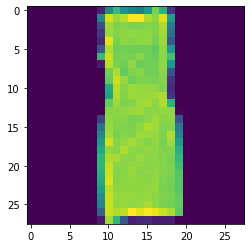

In [77]:
#load the actual hackthon data (fashion-mnist)
images=np.load('data/images.npy')
images=images*255
labels=np.load('data/labels.npy')
#you can visualize it
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(images[1100])

# for i in range(1980,2000):
#     print(labels[i])
#     plt.figure()
#     plt.imshow(images[i], plt.cm.gray_r)

In [84]:
# Data processing
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# sample_train, sample_test, label_train, label_test = train_test_split(
     # digits.data, digits.target, test_size=0.2, random_state=22)

im_test=images.reshape(2000, 28*28)
im_lab=labels
sample_train, sample_test, label_train, label_test = train_test_split(
     im_test, im_lab, test_size=0.2, random_state=1)
n_dim  = 12

pca = PCA(n_components=n_dim).fit(sample_train)
sample_train = pca.transform(sample_train)
sample_test = pca.transform(sample_test)

# Normalise
std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale
samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select
train_size = 1600
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 400
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

print(sample_train[0], label_train[0])
# print(sample_test[0], label_test[0])


[-0.19771525 -0.26633466  0.74022161 -0.35041695 -0.00508334 -0.02686129
 -0.13896993 -0.23913458  0.21552322 -0.34542597 -0.03193802 -0.21618143] True


In [118]:
qc=RealAmplitudes(6, reps=1,entanglement=[[2,3], [0,1],[1,2],[3,4],[4,5]])
# qc=RealAmplitudes(1, reps=1,entanglement=[[0,1]])
encode = qc.bind_parameters(sample_train[0])
encode.measure_all()
encode.decompose().draw("mpl")

with open('quantum_classifier.pickle', 'wb') as fh:
   pickle.dump(encode, fh)


In [119]:
# encode_map = ZZFeatureMap(feature_dimension=n_dim, reps=2, entanglement='linear', insert_barriers=True)
# encode_circuit = encode_map.bind_parameters(sample_train[0])
# # print(type(encode_circuit))
# encode_circuit.decompose().draw(output='mpl')

In [120]:
zz_map = ZZFeatureMap(feature_dimension=n_dim, reps=2, entanglement='linear', insert_barriers=True)
zz_kernel = QuantumKernel(feature_map=zz_map, quantum_instance=Aer.get_backend('statevector_simulator'))

zz_circuit = zz_kernel.construct_circuit(sample_train[0], sample_train[1])
# zz_circuit.decompose().draw(output='mpl')


backend = Aer.get_backend('qasm_simulator')
job = execute(zz_circuit, backend, shots=8192, 
              seed_simulator=1024, seed_transpiler=1024)
counts = job.result().get_counts(zz_circuit)

# full_circuit = encode_circuit.decompose()+zz_circuit.decompose()
# full_circuit.draw(output='mpl')

(1600, 1600)


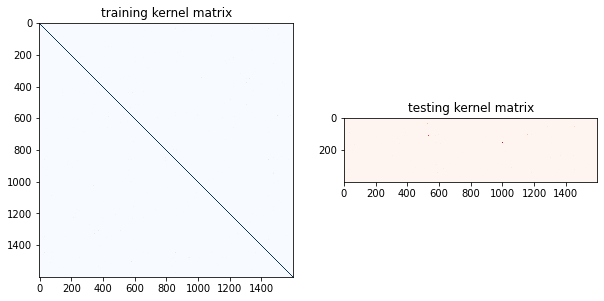

In [121]:
matrix_train = zz_kernel.evaluate(x_vec=sample_train)
matrix_test = zz_kernel.evaluate(x_vec=sample_test, y_vec=sample_train)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(np.asmatrix(matrix_train),
              interpolation='nearest', origin='upper', cmap='Blues')
axs[0].set_title("training kernel matrix")
axs[1].imshow(np.asmatrix(matrix_test),
              interpolation='nearest', origin='upper', cmap='Reds')
axs[1].set_title("testing kernel matrix")
print(matrix_train.shape)
plt.show()

In [122]:
svc = SVC(kernel='precomputed')
# train SVM
svc.fit(matrix_train, label_train)

# score SVM on training data
y_predict = svc.predict(matrix_train)
print('accuracy (sim): ', sum(y_predict == label_train)/(len(label_train)))

print(label_train, y_predict)

accuracy (sim):  1.0
[ True False False ... False  True False] [ True False False ... False  True False]


In [123]:
hist=simulate(encode_circuit)